In [1]:
#import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
#import itertools
import seaborn as sns

In [2]:
ploan = pd.read_csv("data\Bank_Personal_Loan_Modelling.csv")
ploan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
ploan_processed = ploan.dropna().drop(['ID', 'ZIP Code'], axis=1, inplace=False)

<Axes: >

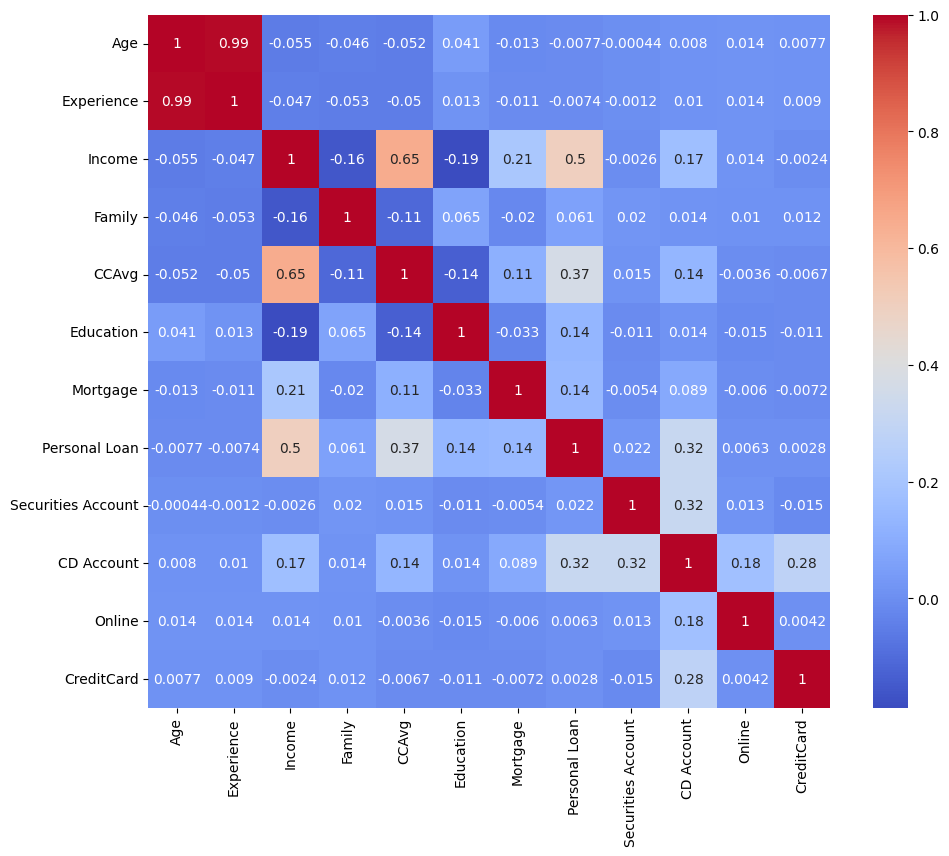

In [4]:
_, ax = plt.subplots(figsize=(11, 9))
corr_matrix = ploan_processed.corr()

# 상관 관계 히트맵 시각화
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)

In [5]:
ploan_processed = sm.add_constant(ploan_processed, has_constant="add") #상수항 추가

In [6]:
ploan_processed.head()

,const,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1.0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,1.0,45,19,34,3,1.5,1,0,0,1,0,0,0
2,1.0,39,15,11,1,1.0,1,0,0,0,0,0,0
3,1.0,35,9,100,1,2.7,2,0,0,0,0,0,0
4,1.0,35,8,45,4,1.0,2,0,0,0,0,0,1


In [7]:
# X, Y 분리
feature_columns = ploan_processed.columns.difference(['Personal Loan'])
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan']

In [8]:
# 학습, 평가 데이터 분리
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y,train_size=0.7,test_size=0.3,random_state=314)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(3500, 12) (1500, 12) (3500,) (1500,)


In [9]:
model = sm.Logit(train_y, train_x)
results = model.fit(method="newton")

Optimization terminated successfully.
         Current function value: 0.124086
         Iterations 9


In [10]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3488
Method:                           MLE   Df Model:                           11
Date:                Mon, 31 Jul 2023   Pseudo R-squ.:                  0.6076
Time:                        15:42:36   Log-Likelihood:                -434.30
converged:                       True   LL-Null:                       -1106.7
Covariance Type:            nonrobust   LLR p-value:                9.613e-282
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.1254      0.076     -1.642      0.101      -0.275       0.024
CCAvg                  0.1265      0.049      2.571      0.010       0.030       0.223
CD Account             3.9745      0.387     10.280      0.000       3.217       4.732
CreditCard            -1.0444      0.250     -4.186      0.000      -1.533      -0.555
Education              1.8850      0.145     13.019      0.000       1.601       2.169
Experience             0.1308      0.076      1.726      0.084      -0.018       0.279
Family                 0.7013      0.091      7.708      0.000       0.523       0.880
Income                 0.0562      0.003     17.189      0.000       0.050       0.063
Mortgage            9.048e-05      0.001      0.135      0.893      -0.001       0.001
Online                -0.7927      0.191     -4.141      0.000      -1.168      -0.417
Securities Account    -1.0143      0.335     -3.027      0.002      -1.671      -0.358
const                -10.7924      2.025     -5.330      0.000     -14.761      -6.824
======================================================================================
"""

In [11]:
np.exp(results.params)

Age                    0.882124
CCAvg                  1.134808
CD Account            53.224808
CreditCard             0.351918
Education              6.586066
Experience             1.139757
Family                 2.016449
Income                 1.057816
Mortgage               1.000090
Online                 0.452640
Securities Account     0.362642
const                  0.000021
dtype: float64

In [12]:
pred_y = results.predict(test_x)
pred_y

3930    0.058766
2431    0.001410
2071    0.000751
2344    0.000032
3499    0.003455
          ...   
463     0.922417
1682    0.000028
2354    0.000054
360     0.002657
767     0.006202
Length: 1500, dtype: float64

In [13]:
def cut_off(y,threshold=0.5):
    Y = y.copy()
    Y[Y>threshold]=1
    Y[Y<=threshold]=0
    return(Y.astype(int))

pred_Y = cut_off(pred_y,0.5)
pred_Y

3930    0
2431    0
2071    0
2344    0
3499    0
       ..
463     1
1682    0
2354    0
360     0
767     0
Length: 1500, dtype: int32

In [14]:
cfmat = confusion_matrix(test_y, pred_Y) #혼동행렬 계산
(cfmat[0,0]+cfmat[1,1])/(cfmat[0,0]+cfmat[0,1]+cfmat[1,0]+cfmat[1,1]) #정확도

0.9506666666666667

AUC: 0.948674614880367


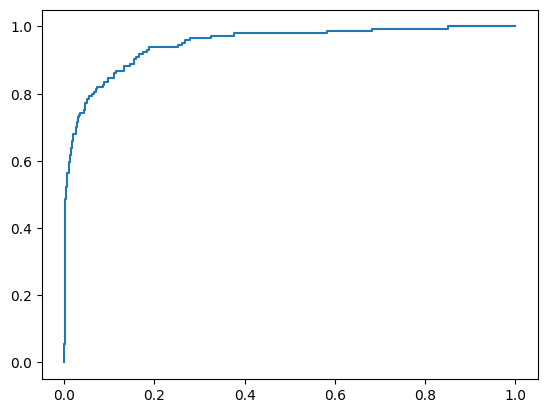

In [15]:
#ROC curve
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)
plt.plot(fpr,tpr)

#AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)